In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [29]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=26):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(20)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(20, 50, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(50)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(50 * 8 * 8, 500)
        self.bn3 = nn.BatchNorm1d(500)
        self.fc2 = nn.Linear(500, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Hyperparameters
learning_rate = 0.001
num_epochs = 30
batch_size = 64
num_classes = 26

# Load your dataset
x_data = np.zeros((4260,1024))
x_data_temp = pd.read_hdf('dataset.h5', key='mydata')['Faces'].to_numpy()
for i in range(4260):
    x_data[i] = x_data_temp[i]
y_data = pd.read_hdf('dataset.h5', key='mydata')['Label'].to_numpy()

label_mapping = {label: idx for idx, label in enumerate(set(y_data))}
def reflect(original_labels):
    new_labels = [label_mapping[label] for label in original_labels]
    return np.array(new_labels)
y_data = reflect(y_data)

# Convert dataset to PyTorch tensors
# put into gpu
x_data = torch.from_numpy(x_data).float().view(-1, 1, 32, 32)
y_data = torch.from_numpy(y_data.astype('int8')).long()
x_data = x_data.to('cuda')
y_data = y_data.to('cuda')

# Split the dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

# Create data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize 
model = SimpleCNN(num_classes=num_classes).to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


tensor([17, 16, 24,  ..., 19,  2,  7], device='cuda:0')

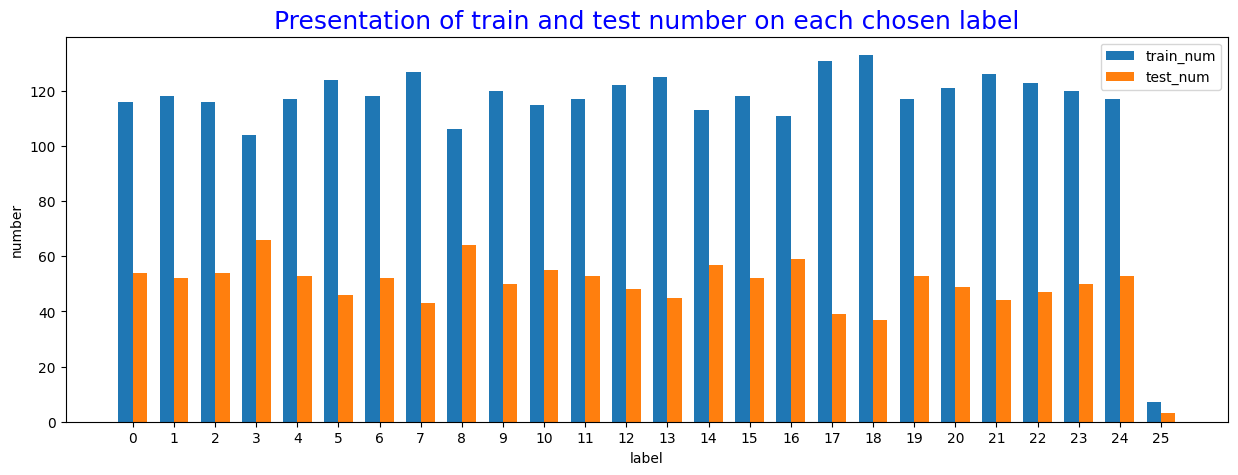

In [36]:
y_train_cpu, y_test_cpu = y_train.cpu().numpy(), y_val.cpu().numpy()
Label_chosen = np.unique(y_train_cpu)
plt.figure(figsize=(15,5))
chosen_rate = []
train_num = []
test_num = []
for i in Label_chosen:
    train_num.append(np.sum(y_train_cpu == i))
    test_num.append(np.sum(y_test_cpu == i))
bar_width = 0.35
x = np.arange(len(Label_chosen))
plt.bar(x - bar_width/2, train_num, bar_width, label='train_num')
plt.bar(x + bar_width/2, test_num, bar_width, label='test_num')
plt.legend()
plt.xlabel('label')
plt.ylabel('number')
plt.xticks(x, Label_chosen)
plt.title('Presentation of train and test number on each chosen label',
          fontsize=18, color = 'b')
plt.show()

In [3]:
train_loss_list = []
val_loss_list = []
val_accuracy_list = []

# Train the model
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to('cuda')
        batch_y = batch_y.to('cuda')

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    # Average training loss for the epoch
    avg_train_loss = total_train_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)

    # Validate the model
    model.eval()
    correct = 0
    total = 0
    total_val_loss = 0.0
    with torch.no_grad():
        for val_batch_x, val_batch_y in val_loader:
            val_batch_x = val_batch_x.to('cuda')
            val_batch_y = val_batch_y.to('cuda')

            val_outputs = model(val_batch_x)
            val_loss = criterion(val_outputs, val_batch_y)
            total_val_loss += val_loss.item()

            _, predicted = torch.max(val_outputs.data, 1)
            total += val_batch_y.size(0)
            correct += (predicted == val_batch_y).sum().item()

    # Average validation loss for the epoch
    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_list.append(avg_val_loss)

    # Validation accuracy for the epoch
    val_accuracy = correct / total
    val_accuracy_list.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')


Epoch [1/30], Train Loss: 0.9801, Val Loss: 0.1757, Val Accuracy: 0.9820
Epoch [2/30], Train Loss: 0.0632, Val Loss: 0.0662, Val Accuracy: 0.9906
Epoch [3/30], Train Loss: 0.0145, Val Loss: 0.0356, Val Accuracy: 0.9961
Epoch [4/30], Train Loss: 0.0061, Val Loss: 0.0291, Val Accuracy: 0.9961
Epoch [5/30], Train Loss: 0.0041, Val Loss: 0.0253, Val Accuracy: 0.9969
Epoch [6/30], Train Loss: 0.0028, Val Loss: 0.0241, Val Accuracy: 0.9961
Epoch [7/30], Train Loss: 0.0022, Val Loss: 0.0227, Val Accuracy: 0.9961
Epoch [8/30], Train Loss: 0.0018, Val Loss: 0.0224, Val Accuracy: 0.9961
Epoch [9/30], Train Loss: 0.0015, Val Loss: 0.0217, Val Accuracy: 0.9969
Epoch [10/30], Train Loss: 0.0013, Val Loss: 0.0196, Val Accuracy: 0.9969
Epoch [11/30], Train Loss: 0.0011, Val Loss: 0.0199, Val Accuracy: 0.9969
Epoch [12/30], Train Loss: 0.0009, Val Loss: 0.0185, Val Accuracy: 0.9961
Epoch [13/30], Train Loss: 0.0008, Val Loss: 0.0187, Val Accuracy: 0.9961
Epoch [14/30], Train Loss: 0.0007, Val Loss: 0.

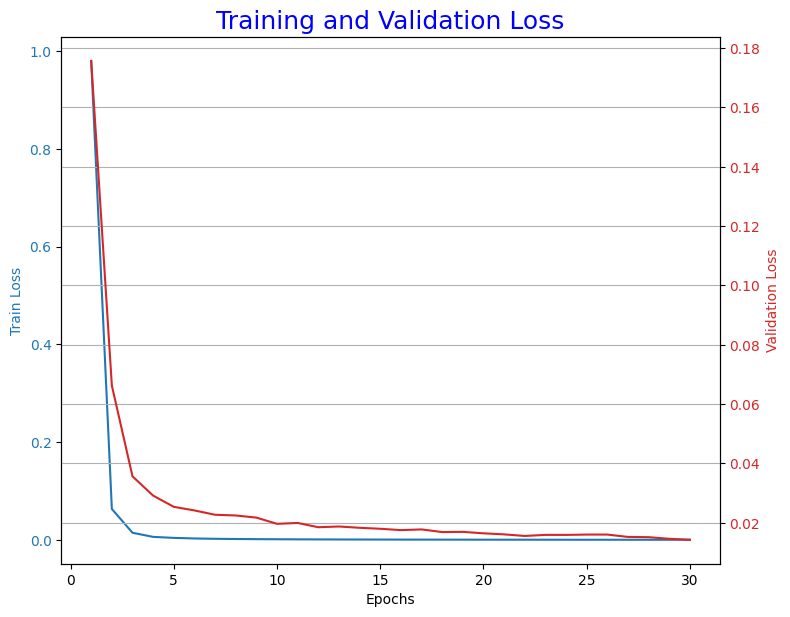

In [6]:
# Plotting
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot Training Loss on the left y-axis
color = 'tab:blue'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Train Loss', color=color)
ax1.plot(range(1, num_epochs + 1), train_loss_list, label='Train Loss', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis for Validation Loss on the right
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Validation Loss', color=color)
ax2.plot(range(1, num_epochs + 1), val_loss_list, label='Validation Loss', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training and Validation Loss',fontsize=18, color = 'b')
plt.grid(True)
plt.show()

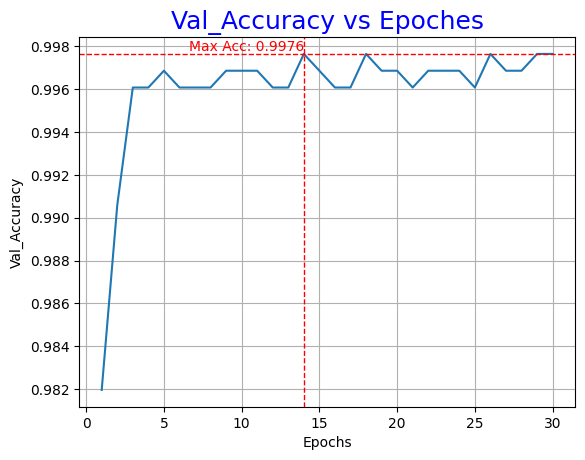

In [5]:
max_value = max(val_accuracy_list)
max_index = val_accuracy_list.index(max_value)
plt.plot(range(1, num_epochs + 1), val_accuracy_list, 
        label='Val_Accuracy')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Val_Accuracy')
plt.title('Val_Accuracy vs Epoches',fontsize=18, color = 'b')
plt.axvline(x=max_index + 1, color='r', 
            linestyle='--', linewidth=1)
plt.axhline(y=max_value, color='r', 
            linestyle='--', linewidth=1)
plt.text(max_index + 1, max_value, 
        f'Max Acc: {max_value:.4f}', 
        color='r', fontsize=10, ha='right', va='bottom')
plt.show()